In [3]:
%cd ..
%matplotlib inline

C:\Users\usuario\Desktop\New_Work


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from sklearn import preprocessing

In [36]:
from src.common_paths import get_data_path, get_output_path
from src.common_paths import get_data_path, get_output_path
from src.utilities import fill_nan_with

In [28]:
def fill_nan_with(data_df, var, value=0, FUN=None, perc=None):
    """Count of NAN and replacement of them by
	:data_df: your pandas data frame 
	:var: variable to be modified "var1"
	:value: value to be added
	:FUN: instead of adding a value yourself, you can add "mean", "median" or "percentile" of that variable
	:perc: value of the percentile when FUN="percentile", range [0-1]
    """
    num_nan=data_df[[var]].isnull().sum().values[0]
    print("Count of NAN values in {x}: {y}".format(x=var, y=num_nan))
    
    if FUN is None and num_nan>0:
        try:
            data_df[var] = data_df[var].replace(np.nan, value)        
            print("----> Replaced by {}".format(value))
        except Exception as error:
            print(error)
            
    elif FUN is not None and num_nan>0:
        try:
            if FUN=="mean":
                stat=np.mean(data_df[var])
                data_df[var] = data_df[var].replace(np.nan, stat)
            elif FUN=="median":
                stat=np.nanmedian(data_df[var])
                data_df[var] = data_df[var].replace(np.nan, stat)
            elif FUN=="percentil":
                try:
                    stat=np.nanpercentile(data_df[var], perc)
                    data_df[var] = data_df[var].replace(np.nan, stat)
                except Exception as error:
                    #WARNING ERROR
                    print(error)
            print("----> Replaced by {} with value {}".format(FUN, stat))
        except Exception as error:
            #WARNING ERROR
            print(error) 
            
    else:
        print("----> Nothing replaced")
    pass

In [29]:
# Define name of columns:
aux_column_names=["id", "company_name", "website_url", "foundation_year", "city", "country"]
# Load the data and calculate the users set and items set cardinalities
c_entities_df = pd.read_csv(os.path.join(get_data_path(), "company_entities.tsv"), 
                            names=aux_column_names, 
                            encoding="utf-8", 
                            sep="\t") # .fillna({"text": "empty"})

c_profiles_df = pd.read_csv(os.path.join(get_data_path(), "company_profiles.tsv"), 
                            names=aux_column_names,
                            encoding="utf-8", 
                            sep="\t") # .fillna({"text": "empty"})


In [7]:
# For the following exploration analysis, will check 
#1. Type of variables the data have been load. Should we correct anything?
#2. Missing values (Should we replace them?)
#3. If there are categorical values that for sure there are, how many categories belong to each categorical variable (could be crucial for the modeling part)
#4. Statistics to understand better the data. 

In [30]:
# 1. Type of variables:
print(c_profiles_df.shape) #10k profiles
print("Number of unique values by id: {}".format(str(len(np.unique(c_profiles_df.id)))))
c_profiles_df.dtypes

(10000, 6)
Number of unique values by id: 10000


id                   int64
company_name        object
website_url         object
foundation_year    float64
city                object
country             object
dtype: object

In [31]:
print(c_entities_df.shape) #~50k entitites
print("Number of unique values by id: {}".format(str(len(np.unique(c_entities_df.id)))))
c_entities_df.dtypes

(49938, 6)
Number of unique values by id: 49937


id                   int64
company_name        object
website_url         object
foundation_year    float64
city                object
country             object
dtype: object

In [32]:
#In entities there is one ID duplicated:
c_entities_df.loc[c_entities_df.duplicated(subset="id")] # ID ---> 342339156
c_entities_df.loc[c_entities_df["id"]==342339156]

# Its the same entity in different year and country/city. If is the same entity but now its in Austria 
# I would delete the second row. If they are different I would concatenate company_name with country to make them unique.
# Because there is only one duplicated it would over add many dimensionalities.
# I will delete it in this case.
c_entities_df.drop_duplicates(subset="id", keep="first", inplace=True) # ID ---> 342339156
c_entities_df.loc[c_entities_df["id"]==342339156]

,id,company_name,website_url,foundation_year,city,country
5590,342339156,BBS GmbH,NaN,2013.0,Bartholomäberg,AT


In [33]:
# Change the ID type.
c_entities_df['id']=c_entities_df['id'].astype('object')
c_profiles_df['id']=c_profiles_df['id'].astype('object')

In [34]:
#2. Check of missing values:
for var in aux_column_names:
    num_nan=c_entities_df[[var]].isnull().sum().values[0]
    print("Entities data - count of NAN values in {x}: {y}".format(x=var, y=num_nan))
    num_nan=c_profiles_df[[var]].isnull().sum().values[0]
    print("Profiles data - count of NAN values in {x}: {y}".format(x=var, y=num_nan))

Entities data - count of NAN values in id: 0
Profiles data - count of NAN values in id: 0
Entities data - count of NAN values in company_name: 0
Profiles data - count of NAN values in company_name: 0
Entities data - count of NAN values in website_url: 19494
Profiles data - count of NAN values in website_url: 644
Entities data - count of NAN values in foundation_year: 477
Profiles data - count of NAN values in foundation_year: 5121
Entities data - count of NAN values in city: 1
Profiles data - count of NAN values in city: 97
Entities data - count of NAN values in country: 0
Profiles data - count of NAN values in country: 93


In [35]:
# There is a huge number of missing values on the entitites websites ~40% and ~50% on profiles foundation year 
# On the website_url will replace them for a value "no_url" and for the foundation_year depending on the range of its values.
fill_nan_with(c_profiles_df, var="website_url", value="leer", FUN=None, perc=None)
fill_nan_with(c_entities_df, var="website_url", value="leer", FUN=None, perc=None)

fill_nan_with(c_profiles_df, var="country", value="leer", FUN=None, perc=None)
fill_nan_with(c_entities_df, var="country", value="leer", FUN=None, perc=None)

fill_nan_with(c_profiles_df, var="city", value="leer", FUN=None, perc=None)
fill_nan_with(c_entities_df, var="city", value="leer", FUN=None, perc=None)

Count of NAN values in website_url: 644
----> Replaced by leer
Count of NAN values in website_url: 19494
----> Replaced by leer
Count of NAN values in country: 93
----> Replaced by leer
Count of NAN values in country: 0
----> Nothing replaced
Count of NAN values in city: 97
----> Replaced by leer
Count of NAN values in city: 1
----> Replaced by leer


In [37]:
# There are profiles with foundation years very old 
c_profiles_df.foundation_year[c_profiles_df["foundation_year"]>1725].describe()
c_profiles_df[c_profiles_df["foundation_year"]<=1725] 

,id,company_name,website_url,foundation_year,city,country
1316,43608,Stadt Essen,www.essen.de,845.0,Essen,DE
2485,65946,Stadt Ulm,http://www.ulm.de,854.0,Ulm,DE
3061,79755,TAKRAF GmbH,http://www.takraf.com/,1725.0,Leipzig,DE
4513,153802,Privatbrauerei Eichbaum GmbH & Co. KG,http://www.eichbaum.de/,1679.0,Mannheim,DE
6377,354337,Bethmann Bank AG,www.bethmannbank.de,1712.0,Frankfurt,DE
7027,405913,Saint-Gobain Deutschland,http://www.saint-gobain.de,1665.0,Aachen,DE
7863,917202,BHS Corrugated Maschinen- und Anlagenbau GmbH,http://www.bhs-world.com/,1717.0,Weiherhammer,DE


There are 49937 entities IDs and 48311 company_names


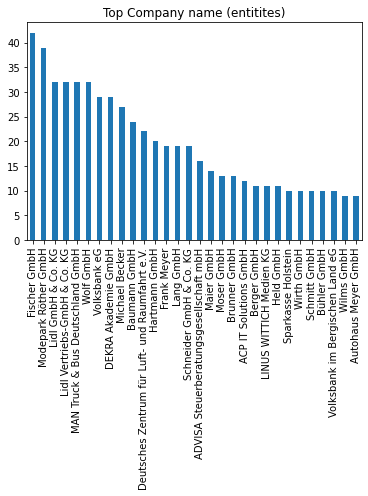

In [38]:
#3. Categorical company_name:
np.sum(c_profiles_df['company_name'].value_counts()>0)# Validity check again


# Plot
print("There are {} entities IDs and {} company_names".format(str(c_entities_df.shape[0]), 
                                                              str(len(np.unique(c_entities_df.company_name)))))


#Plot categorical data
plt.title('Top Company name (entitites)')
c_entities_df['company_name'].value_counts().nlargest(30).plot.bar()

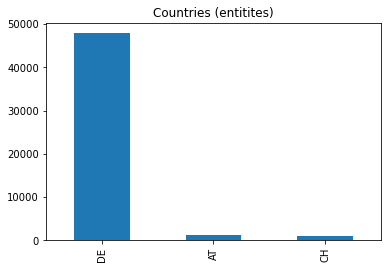

In [39]:
plt.title('Countries (entitites)')
c_entities_df['country'].value_counts().plot.bar() #look some distributions to avoid bias

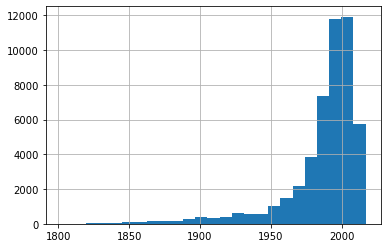

In [40]:
#Distribution of foundation year in order to see the distribution and think if could it be discretized:
numeric_features = "foundation_year"
categorical_features = "country"

#Histogram:
c_entities_df[numeric_features][c_entities_df[numeric_features]>1800].hist(bins=25)
# As is expected is skeewd and probably can be cut it in three categories (thats is choosed to empower old and medium entitites)

In [41]:
# Create another variable called foundation_year_cat to represent the tenure.
c_entities_df['foundation_year_cat'] = ["reifen" if i_value<1965 else "junge" if (i_value>=1965 and i_value<1990) else "experte" for i_value in c_entities_df.foundation_year]
c_entities_df['foundation_year_cat'].value_counts()

experte    32632
junge      10875
reifen      6430
Name: foundation_year_cat, dtype: int64

In [42]:
#Idem in profiles:
c_profiles_df['foundation_year_cat'] = ["reifen" if i_value<1965 else "junge" if (i_value>=1965 and i_value<1990) else "experte" for i_value in c_profiles_df.foundation_year]
c_profiles_df['foundation_year_cat'].value_counts()

experte    8154
reifen      997
junge       849
Name: foundation_year_cat, dtype: int64

In [43]:
# Are the company_names entities/profiles match? And how many?
print(c_profiles_df.merge(c_entities_df, on='company_name', how='inner').shape)
c_profiles_df.merge(c_entities_df, on='company_name', how='left')

# Reasoning:
# 
# There are 10k profiles and 6k of them they matches with entities with that we could create our target for a 
# matriz factorization problem:
# If there werent many many many categories and we could create a target variable 
# I would go for a different approaches:
# 1. Multilabel classifier for ranking (if number of categories entities is small, not in this case) 
# 2. Matriz factorization (if we could create an "interaction" variable)

# Saying that I would test two approaches: 
# . Beacuse is a matching problem (easiest way is to solve it is a "join" operator), will clean/standarize the company_name feature
#   and merge both columns in an left or right join. And compare the solutions with the GT table. The way of measure performance
#   could be the weighted mean of % matched within each profile --> entitites.

# . Then as a test improvement I would convert/map the categorical variables into an embedding for each raw and then 
#   measure the similarity between profile embedding and entities embedding, and fix as a threshold value the limit 
#   for assigning entitities to profile.


(6124, 13)


,id_x,company_name,website_url_x,foundation_year_x,city_x,country_x,foundation_year_cat_x,id_y,website_url_y,foundation_year_y,city_y,country_y,foundation_year_cat_y
0,403,Barfeld & Partner GmbH,http://www.barfeld.de,NaN,Mülheim an der Ruhr,DE,experte,NaN,NaN,NaN,NaN,NaN,NaN
1,462,vergissmeinnicht Werbeagentur GmbH,http://www.vergissmeinnicht-kommunikation.de,2008.0,Überlingen,DE,experte,NaN,NaN,NaN,NaN,NaN,NaN
2,507,Michgehl & Partner GmbH,http://www.michgehl.de,NaN,Nordwalde,DE,experte,NaN,NaN,NaN,NaN,NaN,NaN
3,942,biX Consulting GmbH & Co. KG,http://www.bix-consulting.de,NaN,Ratingen,DE,experte,341383430,www.bix-consulting.de,2008.0,Ratingen,DE,experte
4,985,OneTools GmbH & Co. KG,http://www.onetools.de,NaN,Mainz,DE,experte,312557003,www.onetools.de,2006.0,Mainz,DE,experte
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11008,1866009,MetallArt Treppen GmbH,www.metallart-gmbh.de,1922.0,Salach,DE,reifen,NaN,NaN,NaN,NaN,NaN,NaN
11009,1866125,THE PAULY GROUP GmbH & Co. KG,www.the-pauly-group.com,1991.0,Neu-Eichenberg,DE,experte,NaN,NaN,NaN,NaN,NaN,NaN
11010,1866453,BRICKMAKERS GmbH - Agentur für Digitalisierung,www.brickmakers.de,2010.0,Koblenz,DE,experte,NaN,NaN,NaN,NaN,NaN,NaN
11011,1867435,Planworx AG,www.planworx.de,1987.0,München,DE,junge,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Save data profile/entitites for first/second test:
vars_to_filter = ["id", "company_name", "city", "country", "foundation_year_cat"]
profiles_df = c_profiles_df[vars_to_filter]
profiles_df.to_csv(os.path.join(get_output_path(), "prof_data.csv"), sep=";", index=False)
entities_df = c_entities_df[vars_to_filter]
entities_df.to_csv(os.path.join(get_output_path(), "enti_data.csv"), sep=";", index=False)